<a href="https://colab.research.google.com/github/pande17827/LangGraph/blob/main/3.Reflection%20Agent/2.Reflection%20Agent%20-%20Creating%20Chains%20and%20Building%20the%20graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("hello")

# <b> Setting LLM

In [1]:
!nvidia-smi

Wed May 28 11:03:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Download and install ollama to the system
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [3]:
!pip install -qq pyngrok ollama

In [4]:
import IPython
import subprocess
from pyngrok import ngrok
from typing import Any, Dict, List, Optional

In [5]:
from google.colab import userdata

def start_ollama_server() -> None:
    """Starts the Ollama server."""
    subprocess.Popen(['ollama', 'serve'])
    print("Ollama server started.")


def check_ollama_port(port: str) -> None:
    """Check if Ollama server is running at the specified port."""
    try:
        subprocess.run(['sudo', 'lsof', '-i', '-P', '-n'], check=True, capture_output=True, text=True)
        if any(f":{port} (LISTEN)" in line for line in subprocess.run(['sudo', 'lsof', '-i', '-P', '-n'], capture_output=True, text=True).stdout.splitlines()):
            print(f"Ollama is listening on port {port}")
        else:
            print(f"Ollama does not appear to be listening on port {port}.")
    except subprocess.CalledProcessError as e:
         print(f"Error checking Ollama port: {e}")


def setup_ngrok_tunnel(port: str) -> ngrok.NgrokTunnel:
    """Sets up an ngrok tunnel.

    Args:
        port: The port to tunnel.

    Returns:
        The ngrok tunnel object.

    Raises:
        RuntimeError: If the ngrok authtoken is not set.
    """
    ngrok_auth_token = userdata.get('NGROK_AUTHTOKEN')
    if not ngrok_auth_token:
        raise RuntimeError("NGROK_AUTHTOKEN is not set.")

    ngrok.set_auth_token(ngrok_auth_token)
    tunnel = ngrok.connect(port, host_header=f'localhost:{port}')
    print(f"ngrok tunnel created: {tunnel.public_url}")
    return tunnel

In [6]:
NGROK_PORT = '11434'

In [7]:
start_ollama_server()

check_ollama_port(NGROK_PORT)

Ollama server started.
Ollama is listening on port 11434


In [8]:
ngrok_tunnel = setup_ngrok_tunnel(NGROK_PORT)

ngrok tunnel created: https://4e9b-35-227-91-41.ngrok-free.app


In [16]:
MODEL_ID = 'gemma3:4b'
PROMPT = 'Why is the sky blue?'

In [11]:
import ollama

In [12]:
def query_ollama_with_client(prompt: str, model_id: str, img_path: list = None) -> None:
    """Queries the Ollama server using the `ollama-python` client library.

    Args:
        prompt: The prompt to send to the model.
        model_id: The ID of the model to use.
    """
    try:
        messages=[
            {
                'role': 'user',
                'content': prompt,
            },
        ]

        if img_path:
          messages[0]['images'] = [img_path]

        response = client.chat(
            model=model_id,
            messages=messages
        )
        print("Response from ollama client:")
        print(response['message']['content'])
    except Exception as e:
        print(f"Error querying Ollama with client: {e}")

In [13]:
# Setup an Ollama client with the provided host
client = ollama.Client(host=ngrok_tunnel.public_url)

In [14]:
!pip install langchain
!pip install langchain_community
!pip install langchain_ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00


In [17]:
MODEL_ID="qwen3:8b"
# Load the model at the client
client.pull(model=MODEL_ID)

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [19]:
from langchain_ollama.chat_models import ChatOllama
# Initialize the Ollama model with your ngrok public URL
llm = ChatOllama(
    base_url=ngrok_tunnel.public_url,
    model=MODEL_ID
)




In [20]:
llm.invoke("what is the capital of India")

AIMessage(content="<think>\nOkay, the user is asking for the capital of India. Let me recall the information. I know that India is a country in South Asia, and its capital is a well-known city. From what I remember, the capital is New Delhi. But wait, I should make sure there's no confusion with other cities. For example, Delhi is the name of the city, and New Delhi is the specific area within it that serves as the capital. Sometimes people might refer to the city as Delhi, but the official capital is New Delhi. Let me verify that. Yes, New Delhi is the capital, and it's part of the National Capital Territory of Delhi. So the answer should be New Delhi. I should also mention that Delhi is the name of the city, and New Delhi is the capital. That way, the user gets the correct information without confusion. Alright, that's the answer.\n</think>\n\nThe capital of India is **New Delhi**. It is located in the state of **Delhi**, which is also the name of the city. New Delhi serves as the po

# <b>Step1:-creating Chains

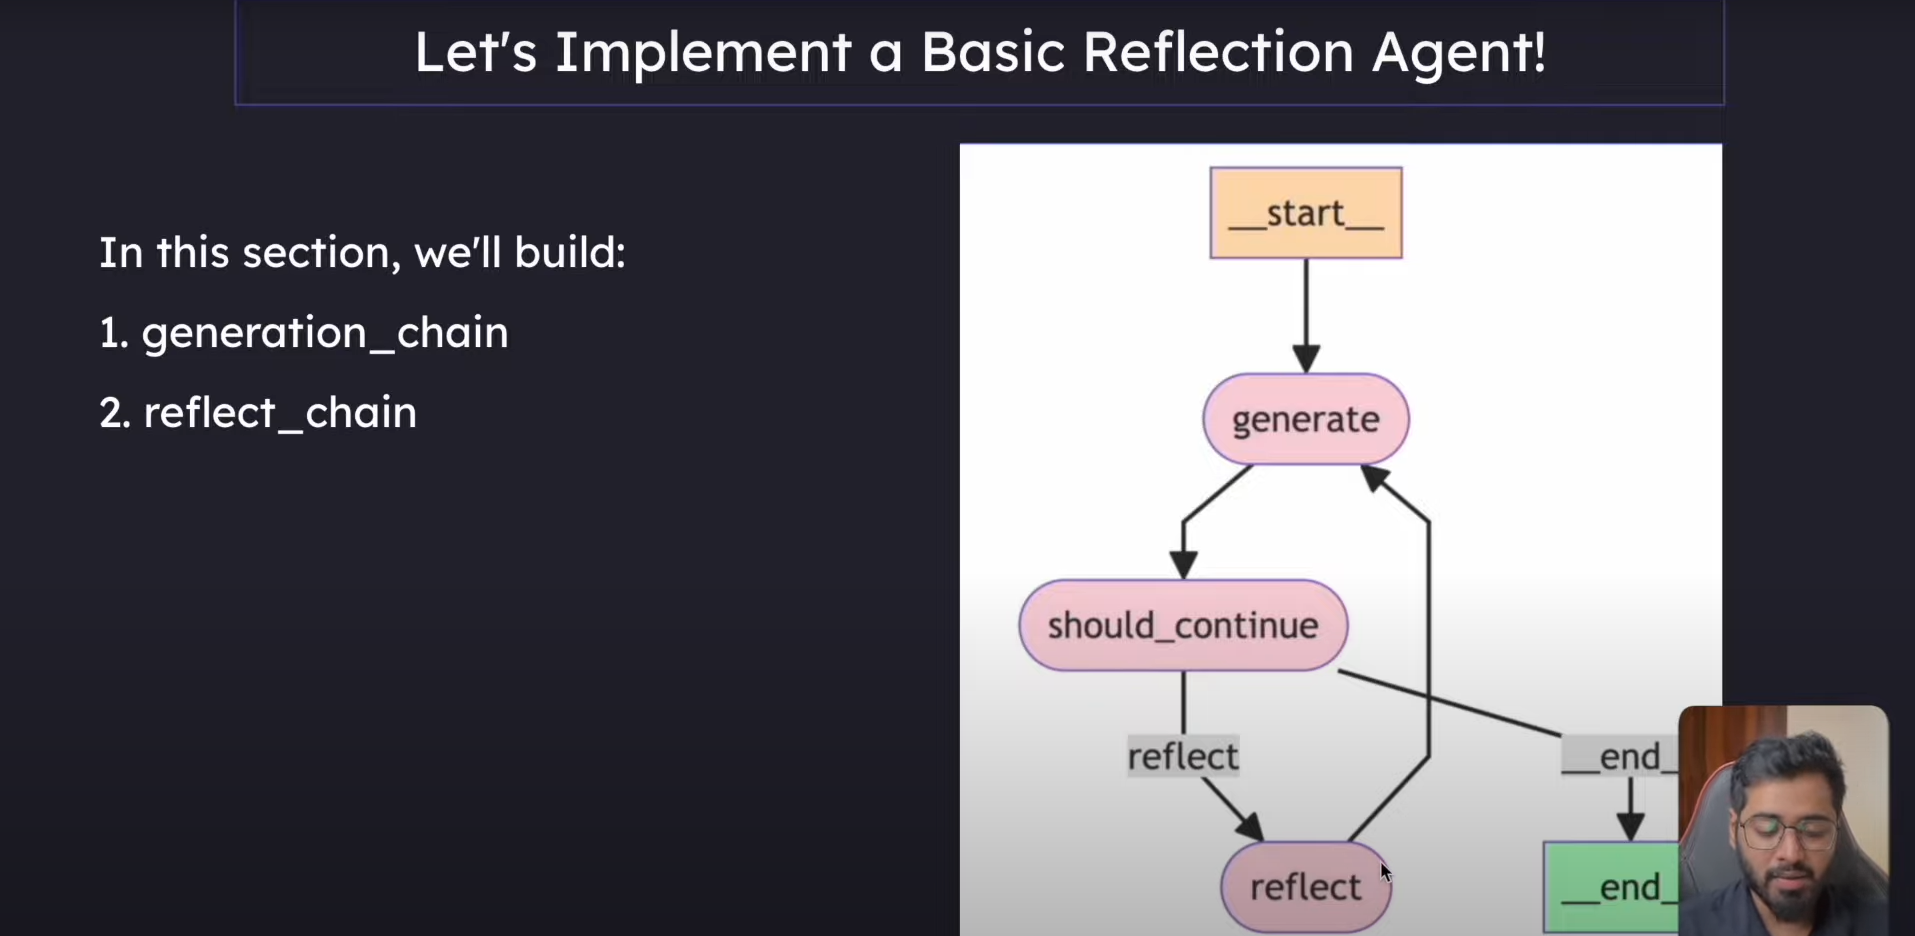

In [21]:
from langchain_core.prompts import ChatPromptTemplate